Fri Jul 4th 2025,
Jakob Balkovec

# Patch Extraction (FGADR Seg-set)

These are just short notes about the dataset that I gathered from my 20 minutes of playing around with it.

```python
{
  "Total_Images": 1,842,
  "Lesion_Masks_Pixel_Level_Annotations": [
    "Microaneurysms_Masks",
    "Hemorrhages_Masks",
    "HardExudate_Masks",
    "SoftExudate_Masks",
    "IRMA_Masks",
    "Neovascularization_Masks"
  ],
  "Original_Images_Directory": "Original_Images"
}
```

Mask format is direct `.png` binary masks.

In [65]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

import json
from shapely.geometry import Polygon, box
from shapely.affinity import translate

# this is to filter "shapely's" warning abt some intersection stuff...
#   I tried debugging it but gave up...if this casues more issues down the road,
#   I'll put more effort into fixing it
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersects.*")
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersection.*")


## Configuration

In [93]:
COLOR_MAP = {
    'hemorrhages': ('blue', 0.3),
    'microaneurysms': ('red', 0.3),
    'hard_exudates': ('green', 0.3),
    'soft_exudates': ('orange', 0.3),
    'irma': ('purple', 0.3),
    'neovascularization': ('cyan', 0.3),
}

TICK_COLOR_MAP = {
    'hemorrhages': 'white',
    'microaneurysms': 'yellow',
    'hard_exudates': 'black',
    'soft_exudates': 'blue',
    'irma': 'white',
    'neovascularization': 'black',
}

MASKS_DIRS = {
    'microaneurysms': 'Microaneurysms_Masks',
    'hemorrhages': 'Hemorrhage_Masks',
    'hard_exudates': 'HardExudate_Masks',
    'soft_exudates': 'SoftExudate_Masks',
    'irma': 'IRMA_Masks',
    'neovascularization': 'Neovascularization_Masks'
}

PATCH_HALF = 12 # since patches are 25x25
PATCH_SIZE = 25

IMAGE_SIZE = r"1280 x 1280"


## Utility Functions

In [67]:
def load_green_clahe_image(image_path, clip_limit=2.0, tile_grid_size=(8, 8)) -> np.ndarray:
    # pre: image_path is a valid path to an image file
    # post: CLAHE enhanced green channel image
    # desc: loads an image and applies CLAHE to the green channel.

    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    green = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_green = clahe.apply(green)

    return enhanced_green

def load_original_image(image_path) -> np.ndarray:
    # pre: image_path is a valid path to an image file
    # post: returns the loaded image as a numpy array
    # desc: loads an image from the specified path

    return cv2.imread(str(image_path))


def plot(img: np.ndarray, type, title = "Not Specified"):
    # pre: img is a 2D numpy array representing a grayscale image
    # post: displays the image in a matplotlib window.
    # desc: plots a 2D grayscale image using matplotlib.

    if type.lower() == "patch":
        figsize = (3, 3)
    elif type.lower() == "image":
        figsize = (6, 6)
    else:
        raise ValueError("type must be either 'patch' or 'image'.")

    if img.ndim != 2:
        raise ValueError("only 2D images are supported.")

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def load_masks(image_name, mask_root, lesion_types: list) -> dict:
    # pre: image_name is a string representing the image file name,
    #      mask_root is a Path object pointing to the directory containing masks
    #      and lesion_types is a list of strings representing lesion types.
    #
    # post: returns a dictionary of masks for each lesion type
    # desc: loads masks for the specified image from the given mask root directory

    # todo: check is the extracted mask is all black if it is, yeet that bih...
    masks = {}

    for lesion in lesion_types:
        folder = MASKS_DIRS[lesion]
        mask_path = mask_root / folder / image_name

        if mask_path.exists():
            mask = cv2.imread(str(mask_path), 0)
            if mask is not None and np.count_nonzero(mask) != 0:
                masks[lesion] = (mask, False)  # not black
            else:
                masks[lesion] = (None, True)   # exists but all black
        else:
            masks[lesion] = (None, "unknown")  # doesn't exist

    return masks

def mask_check(masks):
    # pre: masks have been extracted
    # post: status check
    # desc: prints a status check ([has | no] mask)

    # note: one of my many sanity checks

    status_dict = {}

    for lesion, (mask, is_black) in masks.items():
        if mask is not None:
            if is_black is True:
                status = "** has mask **"
            else:
                status = "has mask"
        else:
            if is_black is True:
                status = "** no mask **"
            elif is_black == "unknown":
                status = "no mask"
            else:
                status = "no mask"

        status_dict[lesion] = {
            "status": status,
            "mask_is_black": is_black
        }

    print(json.dumps(status_dict, indent=4))

def overlay_mask_over_retina(image: np.ndarray, masks_df, line_thickness=1):
    # pre: image is a 2D or 3D numpy array representing the retina image, masks have been extracted
    # post: overlays the masks over the image
    # desc: overlays the masks on the retina image with specified colors and alpha blending

    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    overlay = image.copy()

    for _, row in masks_df.iterrows():
        lesion = row['lesion_type']
        shapes = row.get('shapes', [])

        if lesion not in COLOR_MAP:
            raise ValueError(f"Lesion type '{lesion}' not found in COLOR_MAP.")

        color_name, _ = COLOR_MAP[lesion]  # discarding alpha here bc i'm handling it globally (func level)
        tick_color = TICK_COLOR_MAP.get(lesion, 'white')

        color_bgr = tuple(int(255 * c) for c in mcolors.to_rgba(color_name)[:3][::-1])
        tick_rgb = tuple(int(255 * c) for c in mcolors.to_rgb(tick_color))

        for shape in shapes:
            poly: Polygon = shape['geometry']
            if not isinstance(poly, Polygon):
                continue

            coords = np.array(poly.exterior.coords, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(overlay, [coords], color=color_bgr)
            cv2.polylines(overlay, [coords], isClosed=True, color=color_bgr, thickness=line_thickness)

            cx, cy = poly.centroid.coords[0]
            cv2.drawMarker(overlay, (int(cx), int(cy)), color=tick_rgb, markerType=cv2.MARKER_CROSS, markerSize=10, thickness=1)

    alpha = 0.5  # blending factor
    blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.title("Lesion Overlays")
    plt.axis("off")
    plt.show()

def plot_quadrant_with_lesions(image: np.ndarray, masks_df: pd.DataFrame, quadrant='top_right', alpha=0.4, line_thickness=1):
    # pre: image is a 2D or 3D numpy array representing the retina image,
    #      masks_df is a pandas DataFrame containing lesion data with 'lesion_type' and 'shapes' columns,
    #      quadrant is a string specifying which quadrant to plot ('top_left', 'top_right', 'bottom_left', 'bottom_right')

    # post: displays the specified quadrant of the image with lesions overlaid
    # desc: crops the specified quadrant from the image, filters and shifts the masks, and overlays them on the cropped image

    # note: does the same thing as the function above, except it crops the image to a specific quadrant and shifts the masks accordingly.
    #       it's defined as a separate function due to some extra operations that need to take place like filtering, etc.

    h, w = image.shape[:2]
    x_mid, y_mid = w // 2, h // 2

    quadrant_bounds = {
        'top_left': (0, 0, x_mid, y_mid),
        'top_right': (x_mid, 0, w, y_mid),
        'bottom_left': (0, y_mid, x_mid, h),
        'bottom_right': (x_mid, y_mid, w, h)
    }

    if quadrant not in quadrant_bounds:
        raise ValueError("invalid quadrant -> options ['top_left', 'top_right', 'bottom_left', 'bottom_right']")

    x1, y1, x2, y2 = quadrant_bounds[quadrant]
    region_box = box(x1, y1, x2, y2)
    cropped_image = image[y1:y2, x1:x2]

    def filter_and_shift(masks_df, region_poly, shift_x, shift_y):
        filtered_rows = []
        for _, row in masks_df.iterrows():
            lesion = row['lesion_type']
            filtered_shapes = []
            for shape in row.get('shapes', []):
                poly = shape['geometry']
                if poly.intersects(region_poly):
                    new_poly = translate(poly.intersection(region_poly), xoff=-shift_x, yoff=-shift_y)
                    filtered_shapes.append({'geometry': new_poly})
            if filtered_shapes:
                filtered_rows.append({'lesion_type': lesion, 'shapes': filtered_shapes})
        return pd.DataFrame(filtered_rows)

    quadrant_masks_df = filter_and_shift(masks_df, region_box, x1, y1)

    overlay = cropped_image.copy()
    if overlay.ndim == 2:
        overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)

    for _, row in quadrant_masks_df.iterrows():
        lesion = row['lesion_type']
        shapes = row.get('shapes', [])

        if lesion not in COLOR_MAP:
            continue

        color_name, _ = COLOR_MAP[lesion]
        tick_color = TICK_COLOR_MAP.get(lesion, 'white')
        color_bgr = tuple(int(255 * c) for c in mcolors.to_rgba(color_name)[:3][::-1])
        tick_rgb = tuple(int(255 * c) for c in mcolors.to_rgb(tick_color))

        for shape in shapes:
            poly = shape['geometry']
            coords = np.array(poly.exterior.coords, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(overlay, [coords], color=color_bgr)
            cv2.polylines(overlay, [coords], isClosed=True, color=color_bgr, thickness=line_thickness)
            cx, cy = poly.centroid.coords[0]
            cv2.drawMarker(overlay, (int(cx), int(cy)), color=tick_rgb, markerType=cv2.MARKER_CROSS, markerSize=10, thickness=1)

    blended = cv2.addWeighted(overlay, alpha, cropped_image, 1 - alpha, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.title(f"[{quadrant}] Quadrant with Lesions")
    plt.axis("off")
    plt.show()



## Loading the Data

In [68]:
base_path = Path.cwd()

image_sample = '0001_2.png'
image_path = base_path.parent / 'data' / 'Seg-set' / 'Original_Images' / image_sample

rgb_image = load_original_image(image_path)
image = load_green_clahe_image(image_path)

height, width = image.shape[:2]
dimensions = (height, width)


The image in the dataset is in raw RGB form. Since we agreed on green channel + CLAHE, I'm transforming the images to that format.

On the other hand it's just one function call that can easily be changed/ommitted if needed.

## Image Size

In [69]:
print(f"\n{height} x {width} = {height * width} pixels")

print(f"\t[25 x 25] If we use {PATCH_SIZE}x{PATCH_SIZE} patches, we get {height // PATCH_SIZE} x {width // PATCH_SIZE} = {(height // PATCH_SIZE) * (width // PATCH_SIZE)} patches per image")
print(f"\t[25 x 25] Total number of patches we would get from the dataset = {(height // PATCH_SIZE) * (width // PATCH_SIZE) * 1842} patches")



1280 x 1280 = 1638400 pixels
	[25 x 25] If we use 25x25 patches, we get 51 x 51 = 2601 patches per image
	[25 x 25] Total number of patches we would get from the dataset = 4791042 patches


## Patch Extraction

I yoinked this function from previous notebook [`@see 02_patch_extraction`](https://github.com/anmac42/DR-Research-Summer-25-/blob/main/notebooks/02_patch_extraction.ipynb)

In [70]:
def extract_patches_with_metadata(image, patch_size, source_img_name, skip_non_full_patches=False):
    # pre: image is a NumPy array; patch_size is int > 0; source_img_name is str
    # post: returns a list of dicts, each describing a patch and its metadata
    # desc: slices image into non-overlapping patches and attaches spatial/traceability info

    # note: if skip_non_full_patches is True, it skips patches that do not fit the full patch size
    #  -> mostly patches along the edges that are something like 25 x 20
    #       -> I say mostly because I haven't tested this thoroughly
    #          with all possible patch sizes, just noticed 4 cases

    height, width = image.shape[:2]
    patches = []

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            x1, y1 = x, y
            x2, y2 = x + patch_size, y + patch_size

            if skip_non_full_patches and (x2 > width or y2 > height):
                continue  # skip incomplete patch

            x2 = min(x2, width)
            y2 = min(y2, height)

            patch = image[y1:y2, x1:x2]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)

            patch_info = {
                "source_img": source_img_name,
                "patch_no": len(patches) + 1,
                "patch": patch,
                "center": center,
                "coordinates": {
                    "top_left": (x1, y1),
                    "top_right": (x2 - 1, y1),
                    "bottom_left": (x1, y2 - 1),
                    "bottom_right": (x2 - 1, y2 - 1)
                },
                "label": None,
                "overlap_flag": False
            }

            patches.append(patch_info)

    return patches


In [71]:
patches = extract_patches_with_metadata(image, patch_size=25, source_img_name="0000_1.png")
print(f"[patches]:      Extracted {len(patches)} patches from the image.")


[patches]:      Extracted 2704 patches from the image.


Again, the number differs from the one computed above:

```python
"""
{
  1280 x 1280 = 1638400 pixels
	[25 x 25] If we use 25x25 patches, we get 51 x 51 = 2601 patches per image
	[25 x 25] Total number of patches we would get from the dataset = 4791042 patches
}
"""
```

This is because some of the patches aren't perfect. Some of them are smaller than 25x25 (e.g. `20 x 25` or `25 x 20`), so the number is a bit higher.

# Dataframe

In [72]:
patches_df = pd.DataFrame(patches)

patches_df.head()


,source_img,patch_no,patch,center,coordinates,label,overlap_flag
0,0000_1.png,1,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(12, 12)","{'top_left': (0, 0), 'top_right': (24, 0), 'bo...",None,False
1,0000_1.png,2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(37, 12)","{'top_left': (25, 0), 'top_right': (49, 0), 'b...",None,False
2,0000_1.png,3,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(62, 12)","{'top_left': (50, 0), 'top_right': (74, 0), 'b...",None,False
3,0000_1.png,4,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(87, 12)","{'top_left': (75, 0), 'top_right': (99, 0), 'b...",None,False
4,0000_1.png,5,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(112, 12)","{'top_left': (100, 0), 'top_right': (124, 0), ...",None,False


## Sanity Checks

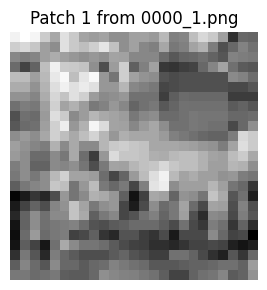

In [73]:
plot(patches_df['patch'][563], type="patch", title=f"Patch {patches_df['patch_no'][0]} from {patches_df['source_img'][0]}")


I picked a random index (one that wasn't giving me a black image), to double check that the patch extraction is working correctly.

## Labeling the Patch

### Masks

Since my older approach won't work here (XML vs. Binary Masks), I need to find a workaround. An adapter is not an option. My approach is to rely heavy on the `cv2` library. I'm going to load all the masks into a dictionary, separate them by symptoms/lesion types. Some of them are going to be `null` or `None`, but that's fine. I can just skip them. 

I'm then going to use `findContours()` to, well, find the contours of the lesions in the masks. This will give me the bounds of the lesions, to measure size, and have the ability to resolve labeling issues using my area based approach. I also plan on turning every patch into a polygon, so I can use the `cv2` library to check if the patch is inside the lesion mask or not.

I plan on storing the dictionary with the masks in the dataframe, so I can access them later on.

Everything else (regarding labeling, etc.) remains the same. [`@see 02_patch_extraction`](https://github.com/anmac42/DR-Research-Summer-25-/blob/main/notebooks/02_patch_extraction.ipynb)

**MODIFICATION**: The labels are now stored as a `list` due to the fact they have more built in functions and operators supported

In [74]:
mask_root = base_path.parent / 'data' / 'Seg-set'
masks = load_masks(image_sample, mask_root, list(MASKS_DIRS.keys()))

mask_check(masks)


{
    "microaneurysms": {
        "status": "has mask",
        "mask_is_black": false
    },
    "hemorrhages": {
        "status": "has mask",
        "mask_is_black": false
    },
    "hard_exudates": {
        "status": "** no mask **",
        "mask_is_black": true
    },
    "soft_exudates": {
        "status": "** no mask **",
        "mask_is_black": true
    },
    "irma": {
        "status": "no mask",
        "mask_is_black": "unknown"
    },
    "neovascularization": {
        "status": "no mask",
        "mask_is_black": "unknown"
    }
}


Again, this is one of my many sanity checks, just to make sure everything is working as expected. I labeled each lesion type with either `has mask | no mask` since some of the lesions provide/do not provide mask information. I also excluded the ones that are completely black (i.e. no lesion present). I think this is safe to do because I am using the `np` function `count_nonzero()` to check if the patch is black or not. `count_nonzero()` counts the number of non-zero pixel values, allowing you to determine if all pixels are indeed black (i.e., zero). You can always check for yourself (use the `json` dict above and manually search for the mask)

## Shapes

For the sake of making my life easier, I'm turning this into a `pandas` DataFrame. I think this is the best way to go about it, so when designing the pipeline, this will be done under the hood.

In [75]:
masks_df = pd.DataFrame(masks).T
masks_df.columns = ['mask', 'mask_is_black']
masks_df = pd.DataFrame.from_dict(masks, orient='index', columns=['mask', 'mask_is_black'])
masks_df.reset_index(inplace=True)
masks_df.rename(columns={'index': 'lesion_type'}, inplace=True)

masks_df.head()


,lesion_type,mask,mask_is_black
0,microaneurysms,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False
1,hemorrhages,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",False
2,hard_exudates,None,True
3,soft_exudates,None,True
4,irma,None,unknown


### Extracting the Shape

In [76]:
def process_mask_shapes(df):
    # pre: df is a DataFrame with 'lesion_type' and 'mask' columns
    # post: returns a DataFrame with shape features extracted from masks
    # desc: processes each mask to extract contours and shape features

    def get_contours(mask: np.ndarray):
        # pre: mask is a binary image (numpy array)
        # post: returns contours found in the mask
        # desc: finds contours in the binary mask using OpenCV

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contours

    def contour_to_polygon(contour):
        # pre: contour is a numpy array of shape (n, 1, 2) representing a contour
        # post: returns a Polygon object if valid, otherwise None
        # desc: converts a contour to a Polygon object if it has enough points

        if contour.shape[0] < 3:
            return None
        contour = contour.squeeze()
        return Polygon(contour) if Polygon(contour).is_valid else None

    def extract_shape_features(polygon: Polygon):
        # pre: polygon is a valid shapely Polygon object
        # post: returns a dictionary with shape features
        # desc: extracts area, perimeter, centroid, bounding box, and geometry from the polygon

        return {
            'area': polygon.area,
            'perimeter': polygon.length,
            'centroid': (polygon.centroid.x, polygon.centroid.y),
            'bbox': polygon.bounds,
            'geometry': polygon
        }

    n_polygons_list = []
    shapes_list = []

    for _, row in df.iterrows():
        mask = row['mask']

        if mask is None:
            n_polygons_list.append(0)
            shapes_list.append([])
            continue

        contours = get_contours(mask)
        polygons = [contour_to_polygon(c) for c in contours if contour_to_polygon(c) is not None]
        shape_features = [extract_shape_features(p) for p in polygons]

        n_polygons_list.append(len(shape_features))
        shapes_list.append(shape_features)

    df = df.copy()
    df['n_polygons'] = n_polygons_list
    df['shapes'] = shapes_list

    return df


In [77]:
masks_df = process_mask_shapes(masks_df)


### Turning Patches into `shapely` Polygons

In [78]:
def label_patches_using_polygons(masks_df, patches_df):

    def patch_to_polygon(coord_dict):
        return Polygon([
            coord_dict['top_left'],
            coord_dict['top_right'],
            coord_dict['bottom_right'],
            coord_dict['bottom_left']
        ])

    def label_patch(patch_poly, masks_df):
        labels = []
        for _, row in masks_df.iterrows():
            lesion_type = row['lesion_type']
            shapes = row.get('shapes', [])
            for shape in shapes:
                lesion_poly = shape['geometry']
                if patch_poly.intersects(lesion_poly):
                    labels.append(lesion_type)
                    break  # one match per lesion_type is enough
        return labels if labels else None

    df = patches_df.copy()

    df['patch_polygon'] = df['coordinates'].apply(patch_to_polygon)
    df['label'] = df['patch_polygon'].apply(lambda poly: label_patch(poly, masks_df))
    df['overlap_flag'] = df['label'].apply(lambda x: x is not None)

    # add one hot now cuz why not...
    lesion_types = masks_df['lesion_type'].unique().tolist()
    for lesion in lesion_types:
        df[lesion] = df['label'].apply(lambda x: lesion in x if x else False)

    return df


In [79]:
labeled_df = label_patches_using_polygons(masks_df, patches_df)
labeled_df[labeled_df['label'].apply(lambda x: x == ['microaneurysms'])].head(n=2)


,source_img,patch_no,patch,center,coordinates,label,overlap_flag,patch_polygon,microaneurysms,hemorrhages,hard_exudates,soft_exudates,irma,neovascularization
185,0000_1.png,186,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(737, 87)","{'top_left': (725, 75), 'top_right': (749, 75)...",[microaneurysms],True,"POLYGON ((725 75, 749 75, 749 99, 725 99, 725 ...",True,False,False,False,False,False
385,0000_1.png,386,"[[50, 57, 80, 102, 77, 80, 82, 87, 87, 84, 77,...","(537, 187)","{'top_left': (525, 175), 'top_right': (549, 17...",[microaneurysms],True,"POLYGON ((525 175, 549 175, 549 199, 525 199, ...",True,False,False,False,False,False


In [80]:
labeled_df[labeled_df['label'].apply(lambda x: isinstance(x, list) and len(x) > 1)]


,source_img,patch_no,patch,center,coordinates,label,overlap_flag,patch_polygon,microaneurysms,hemorrhages,hard_exudates,soft_exudates,irma,neovascularization


Since this returns an empty frame, it means there is no overlap. 

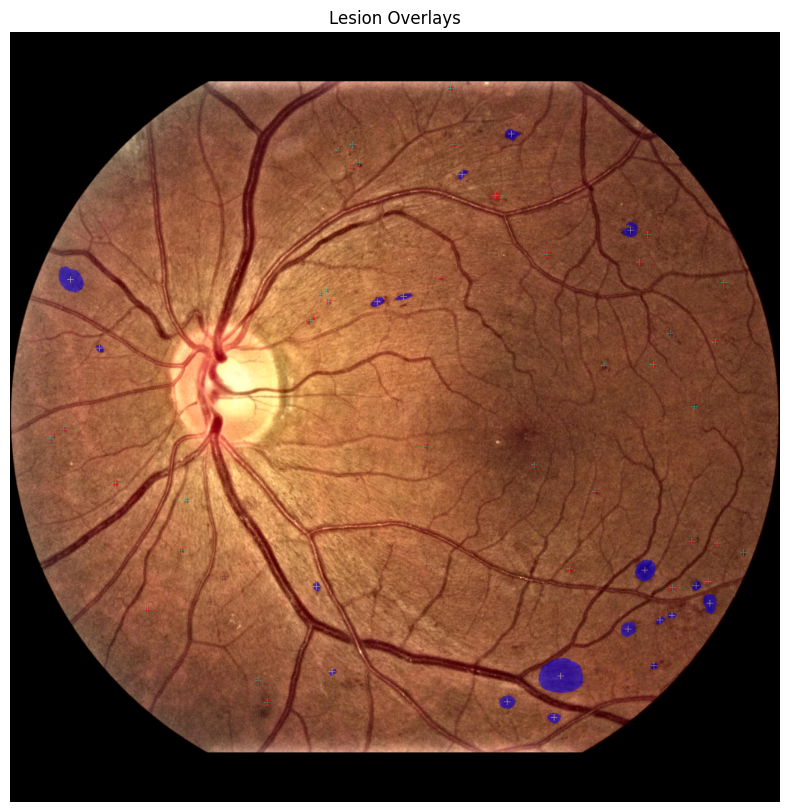

In [81]:
overlay_mask_over_retina(rgb_image, masks_df)


This confirms the remark above this. I don't see any overlays nor does the algorithm detect any. This is a good sign, since it means the patches are not overlapping and the labeling is correct.

> **Note**: Using RGB here just for visualization purposes. The patches are actually in green channel + CLAHE format.

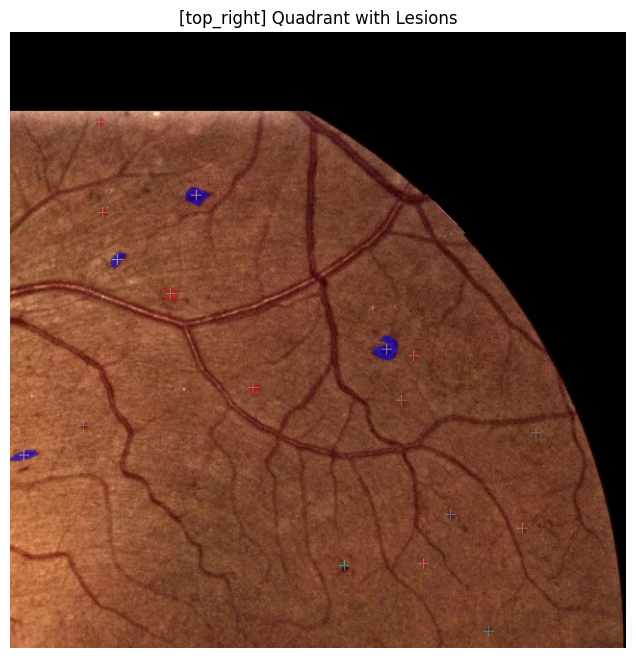

In [82]:
plot_quadrant_with_lesions(rgb_image, masks_df, quadrant='top_right', alpha=0.5, line_thickness=1)


Top right quadrant zoomed in (No overlap). 

> **Note**: Using RGB here just for visualization purposes. The patches are actually in green channel + CLAHE format.

## New Set of Images and Masks

Since the example above returned an empty frame, I can assume that the patches are not overlapping and the labeling is correct for that image, but I can't generalize it. I plan of testing this with a few more images, just to be sure.